In [22]:
%matplotlib

import numpy as np
import cv2 as cv
import matplotlib.pyplot as plt

cv.destroyAllWindows()

Using matplotlib backend: Qt5Agg


In [23]:
camera = cv.VideoCapture(0)

ret,frame = camera.read()
cv.imshow('Foto',frame)

camera.release()

In [24]:
roi = None
roiPts = []
cropping = False

def selectROI(event, x, y, flags, param):
    global frame, roi, roiPts, cropping

    if event == cv.EVENT_LBUTTONDOWN:
        roiPts = [(x, y)]
        cropping = True

    elif event == cv.EVENT_LBUTTONUP:
        roiPts.append((x, y))
        cropping = False
        
        cp = frame.copy()
        cv.rectangle(cp, roiPts[0], roiPts[1], (0, 255, 0), 2)
        cv.imshow("Foto", cp)
        roi = frame[roiPts[0][1]:roiPts[1][1], roiPts[0][0]:roiPts[1][0]]
        cv.imshow("ROI", roi)
        
cv.setMouseCallback("Foto", selectROI)

print("Click & Drag to select ROI - Hit any key to continue")
cv.waitKey(0)
cv.destroyAllWindows()
if roi is not None:
    print("ROI correctly selected")

Click & Drag to select ROI - Hit any key to continue
ROI correctly selected


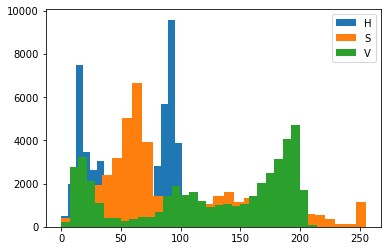

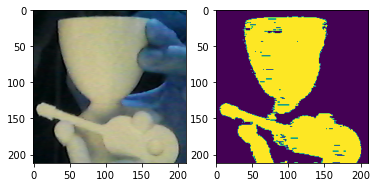

In [25]:
%matplotlib inline

hsv_roi =  cv.cvtColor(roi, cv.COLOR_BGR2HSV)
plt.clf()
plt.hist(hsv_roi[:,:,0].ravel(), bins=30, label="H")
plt.hist(hsv_roi[:,:,1].ravel(), bins=30, label="S")
plt.hist(hsv_roi[:,:,2].ravel(), bins=30, label="V")
plt.legend()

mask = cv.inRange(hsv_roi, np.array((40., 10., 150.)), np.array((100., 80., 230.)))
roi_hist = cv.calcHist([hsv_roi],[0],mask,[180],[0,180])
cv.normalize(roi_hist,roi_hist,0,255,cv.NORM_MINMAX)

plt.figure()
plt.subplot(121)
plt.imshow(roi);
plt.subplot(122)
plt.imshow(mask);

In [26]:
x = roiPts[0][0]
y = roiPts[0][1]
w = roiPts[1][0] - roiPts[0][0]
h = roiPts[1][1] - roiPts[0][1]
track_window = (x, y, w, h)
print(track_window)

# Condición de terminación: 10 iteraciones o moverse al menos 1pt
#----------------------------------------------------------------
term_crit = ( cv.TERM_CRITERIA_EPS | cv.TERM_CRITERIA_COUNT, 1, 10 )

camera = cv.VideoCapture(0)

while(1):
    ret, frame = camera.read()
    if ret == True:
        hsv = cv.cvtColor(frame, cv.COLOR_BGR2HSV)
        dst = cv.calcBackProject([hsv],[0],roi_hist,[0,180],1)
        dst = cv.medianBlur(dst,9)
        
        ret, track_window = cv.CamShift(dst, track_window, term_crit)
        
        # Dibujamos la ventana sobre la imagen
        #=====================================
        
        # Con escalamiento y rotación de la ventana de seguimiento
        #---------------------------------------------------------
        #pts = cv.boxPoints(ret)                      # Encuentra los 4 vértices del rectángulo rotado
        #pts = np.int0(pts)                           # int0 (entero usado para indexado)
        #img2 = cv.polylines(frame,[pts],True, 255,2) # Dibujo del rectángulo
        
        # Con escalamiento de ventana - Sin rotación
        #-------------------------------------------
        x,y,w,h = track_window
        img2 = cv.rectangle(frame, (x,y), (x+w,y+h), 255,2)
        
        cv.imshow('Seguimiento',img2)
        cv.imshow('Mask',dst)
        
        k = cv.waitKey(30) & 0xff
        if k == 27:
            break
    else:
        break
cv.destroyAllWindows()
camera.release()

(295, 265, 211, 212)
